In [1]:
from pathlib import Path

arches = (
    "linux-64",
    "win-64",
    "osx-64",
    "noarch",
    "linux-ppc64le",
    "linux-aarch64",
    "osx-arm64"
)


def remove_existing(fname):
    if fname.is_file():
        fname.unlink()


# Clean old files first.
path = Path(".")
for arch in arches:
    remove_existing(path.joinpath(f"repodata-{arch}.json"))
    remove_existing(path.joinpath(f"repodata-cf201901-{arch}.json"))

In [2]:
import shutil

import requests


def download_file(url, fname):
    with requests.get(url, stream=True) as r:
        with open(fname, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return fname

In [3]:
import tqdm

In [4]:
for arch in tqdm.tqdm(arches):
    download_file(
        f"https://conda.anaconda.org/conda-forge/{arch}/repodata.json",
        f"repodata-{arch}.json",
    )
    download_file(
        f"https://conda.anaconda.org/conda-forge/label/cf201901/{arch}/repodata.json",
        f"repodata-cf201901-{arch}.json",
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.97s/it]


In [5]:
import gzip


def read_json(fname):
    with gzip.GzipFile(fname, "r") as f:
        return pd.io.json.loads(f.read())

In [6]:
import glob

import pandas as pd

packages = []
for fname in glob.glob("repodata-*.json"):
    data = read_json(fname)
    df = pd.DataFrame(data["packages"].values())
    df.loc[:, "filename"] = data["packages"].keys()
    packages.append(df)

In [7]:
df = pd.concat(packages, sort=False, ignore_index=True)

In [8]:
df = df.drop_duplicates(subset=["subdir", "filename"])

In [9]:
df.loc[:, "timestamp"] = pd.to_datetime(df.timestamp, unit="ms")

In [10]:
len(df)

708582

In [11]:
df.timestamp.isnull().sum()

97304

In [46]:
has_ts = df[df.timestamp.notnull()]
has_ts.head()

,build,build_number,depends,license,license_family,md5,name,sha256,size,subdir,...,platform,app_own_environment,filename,operatingsystem,target-triplet,has_prefix,machine,binstar,requires,noarch
0,py36h1af98f8_1,1.0,"[_openmp_mutex >=4.5, astropy >=2.0, cached-pr...",MIT,MIT,d65ab674acf3b7294ebacaec05fc5b54,21cmfast,1154fceeb5c4ee9bb97d245713ac21eb1910237c724d2b...,414494.0,linux-64,...,NaN,NaN,21cmfast-3.0.2-py36h1af98f8_1.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,py36h2e3f83d_0,0.0,"[_openmp_mutex >=4.5, astropy >=2.0, cached-pr...",MIT,MIT,bc13aa58e2092bcb0b97c561373d3905,21cmfast,97ec377d2ad83dfef1194b7aa31b0c9076194e10d995a6...,411271.0,linux-64,...,NaN,NaN,21cmfast-3.0.2-py36h2e3f83d_0.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,py37h48b2cff_0,0.0,"[_openmp_mutex >=4.5, astropy >=2.0, cached-pr...",MIT,MIT,8aa1a00af8a99aab03dae85fde9c169a,21cmfast,3a8d86f7ca55c8b966a0861970f6160ddd7f2f3853ad8f...,388716.0,linux-64,...,NaN,NaN,21cmfast-3.0.2-py37h48b2cff_0.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,py37hd45b216_1,1.0,"[_openmp_mutex >=4.5, astropy >=2.0, cached-pr...",MIT,MIT,41bde8a484725898b237ea2fbd037146,21cmfast,b80028d25090843243d3a6c30bd195793545d593b7efc0...,391019.0,linux-64,...,NaN,NaN,21cmfast-3.0.2-py37hd45b216_1.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,py38h9a4a7a8_1,1.0,"[_openmp_mutex >=4.5, astropy >=2.0, cached-pr...",MIT,MIT,96c55fc31ce3d808ecaedc922a082d41,21cmfast,383a4dde58ca57811108d44cde454e04d6ac861e77e5f2...,432652.0,linux-64,...,NaN,NaN,21cmfast-3.0.2-py38h9a4a7a8_1.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
import matplotlib.pyplot as plt

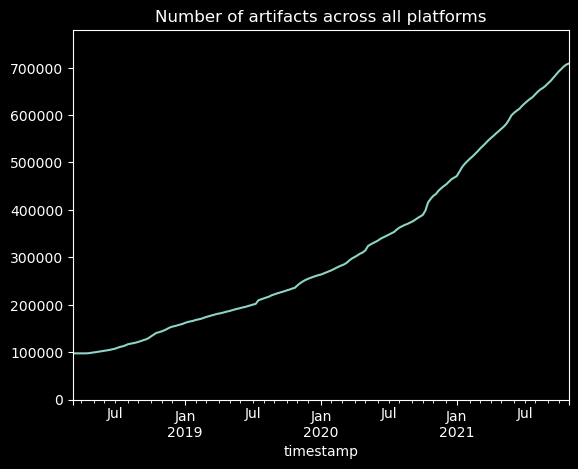

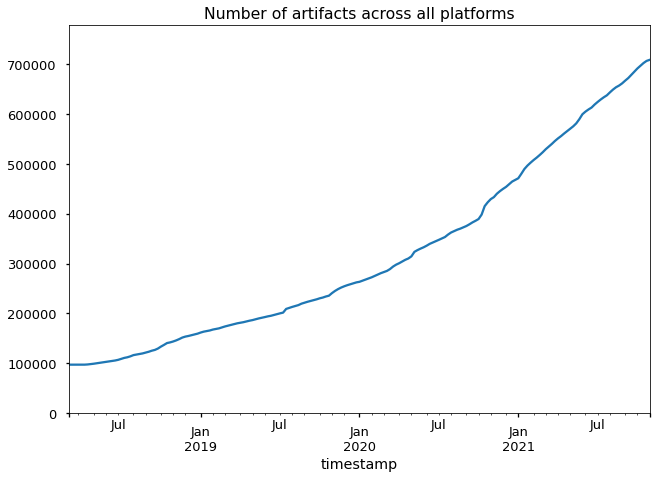

In [48]:
fill_val = "2018-03-01"
df_has = (
    df.fillna(pd.to_datetime(fill_val)).sort_values("timestamp").set_index("timestamp")
)
df_has.loc[:, "package_count"] = list(range(1, len(df_has) + 1))
df_arrival = df_has.groupby(df_has.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_arrival[df_arrival.index > fill_val].plot(
            title="Number of artifacts across all platforms",
            ylim=(0, df_arrival.max() * 1.1),
            ax=ax
    #         figsize=(16, 9),
        )
        fig.savefig(f"plots/n_artifacts-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [57]:
df_size.cumsum()

timestamp
2017-08-07/2017-08-13    6.856697e+07
2017-09-11/2017-09-17    3.081748e+08
2017-09-18/2017-09-24    3.084865e+08
2017-10-16/2017-10-22    3.084902e+08
2018-01-15/2018-01-21    3.084948e+08
                             ...     
2021-09-27/2021-10-03    3.724297e+12
2021-10-04/2021-10-10    3.785088e+12
2021-10-11/2021-10-17    3.833986e+12
2021-10-18/2021-10-24    3.876830e+12
2021-10-25/2021-10-31    3.887814e+12
Freq: W-SUN, Name: size, Length: 194, dtype: float64

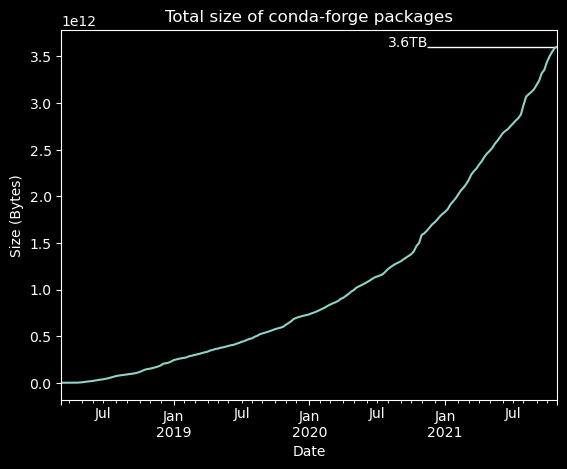

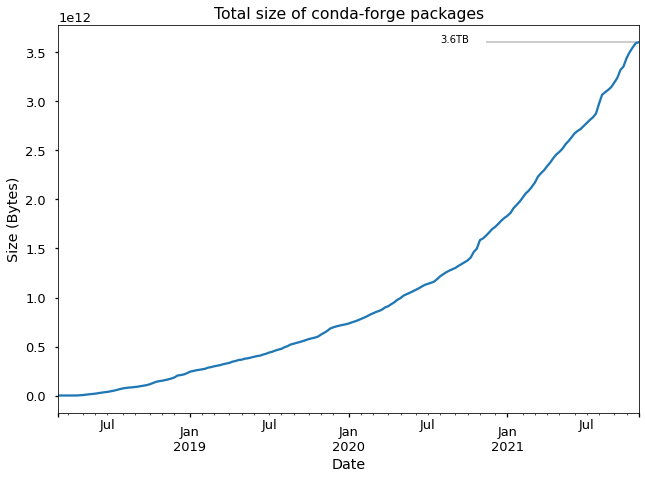

In [64]:
fill_val = "2018-03-01"
df_has = (
    df.fillna(pd.to_datetime(fill_val)).sort_values("timestamp").set_index("timestamp")
)
df_has.loc[:, "package_count"] = list(range(1, len(df_has) + 1))
df_size = df_has.groupby(df_has.index.to_period("W"))['size'].sum()
df_size_plot = df_size[df_size.index > fill_val].cumsum()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_size_plot.plot(
            title="Total size of conda-forge packages",
            xlabel="Date",
            ylabel="Size (Bytes)",
            # ylim=(0, df_size.max() * 1.1),
            ax=ax
    #         figsize=(16, 9),
        )
        x = df_size_plot.index[-1]
        y = df_size_plot[-1]
        ax.arrow(x, y, -50, 0, shape='right')
        ax.text(x-65, y, s=f'{round(y/1e12, 1)}TB')
        fig.savefig(f"plots/n_artifacts-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [29]:
df_first[-1]

timestamp
2017-08-07/2017-08-13        1
2017-09-11/2017-09-17       11
2017-10-16/2017-10-22       12
2018-01-15/2018-01-21       13
2018-02-26/2018-03-04      301
                         ...  
2021-09-27/2021-10-03    15569
2021-10-04/2021-10-10    15674
2021-10-11/2021-10-17    15773
2021-10-18/2021-10-24    15838
2021-10-25/2021-10-31    15871
Freq: W-SUN, Name: package_count, Length: 192, dtype: int64

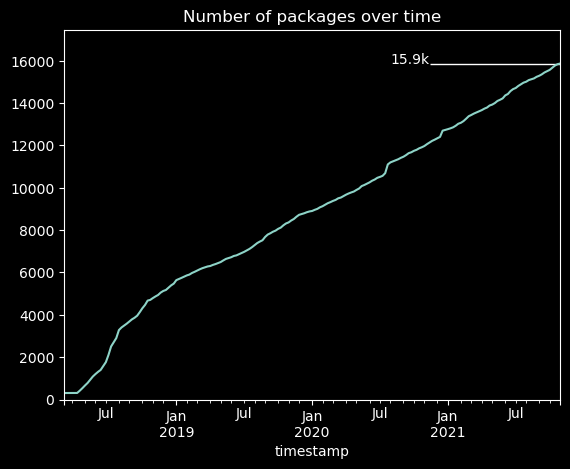

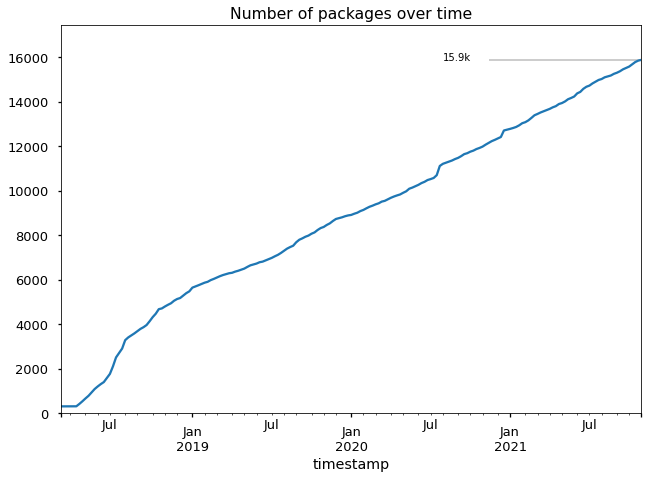

In [37]:
fill_val = "2018-03-01"
x = (
    df.sort_values("timestamp")
    .fillna(pd.to_datetime(fill_val))
    .groupby(df.name)
    .first()
)
first_date = pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_first[df_first.index > fill_val].plot(
            title="Number of packages over time",
            ylim=(0, df_first.max() * 1.1),
            ax=ax
#             figsize=(16, 9),
        )
        x = df_first.index[-1]
        y = df_first[-1]
        ax.arrow(x, y, -50, 0, shape='right')
        ax.text(x-65, y, s=f'{round(y/1e3, 1)}k')
        fig.savefig(f"plots/n_feedstocks-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [16]:
ddf = df_first[df_first.index > fill_val]

In [17]:
inds = [40, 92, 92+52, -1]
[ddf.index.to_numpy()[ind] for ind in inds]

[Period('2019-01-07/2019-01-13', 'W-SUN'),
 Period('2020-01-06/2020-01-12', 'W-SUN'),
 Period('2021-01-04/2021-01-10', 'W-SUN'),
 Period('2021-10-25/2021-10-31', 'W-SUN')]

In [18]:
for i in range(len(inds)-1):
    print(
        ddf.index.to_numpy()[inds[i]],
        ddf.index.to_numpy()[inds[i+1]], 
        ddf.to_numpy()[inds[i+1]] - ddf.to_numpy()[inds[i]]
    )

2019-01-07/2019-01-13 2020-01-06/2020-01-12 3268
2020-01-06/2020-01-12 2021-01-04/2021-01-10 3850
2021-01-04/2021-01-10 2021-10-25/2021-10-31 3061


In [19]:
arch_df = {}
for arch in arches:
    fill_val = "2018-03-01"
    x = (
        df.sort_values("timestamp")
        .fillna(pd.to_datetime(fill_val))
        .loc[df.subdir == arch]
        .groupby(df.name)
        .first()
    )
    first_date = (
        pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
    )
    first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
    df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
    arch_df[arch] = df_first

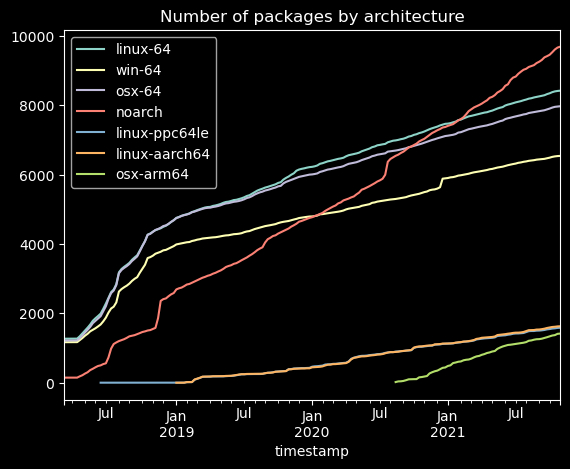

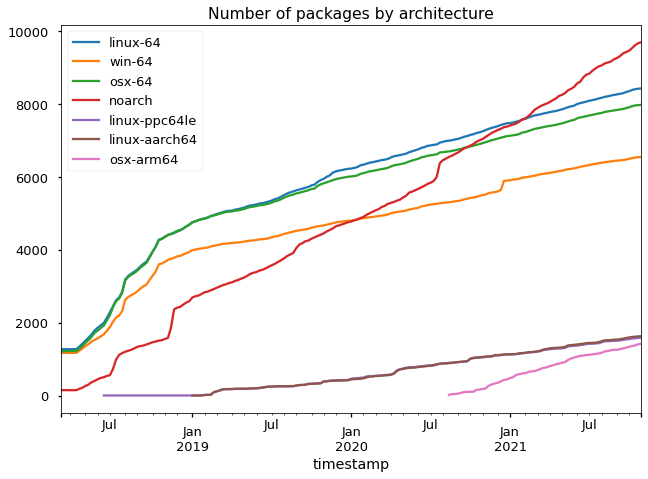

In [20]:
import matplotlib.pyplot as plt

for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        plot_df = pd.DataFrame(arch_df)
        plot_df.ffill()[plot_df.index > fill_val].plot(
            title="Number of packages by architecture",
            ax=ax
        )
        fig.savefig(f"plots/n_feedstocks_by_arch-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [21]:
arch_df

{'linux-64': timestamp
 2017-09-18/2017-09-24       1
 2018-02-26/2018-03-04    1266
 2018-03-05/2018-03-11    1271
 2018-04-09/2018-04-15    1274
 2018-04-16/2018-04-22    1342
                          ... 
 2021-09-27/2021-10-03    8350
 2021-10-04/2021-10-10    8383
 2021-10-11/2021-10-17    8405
 2021-10-18/2021-10-24    8417
 2021-10-25/2021-10-31    8425
 Freq: W-SUN, Name: package_count, Length: 189, dtype: int64,
 'win-64': timestamp
 2017-10-16/2017-10-22       1
 2018-01-15/2018-01-21       2
 2018-02-26/2018-03-04    1171
 2018-04-09/2018-04-15    1173
 2018-04-16/2018-04-22    1230
                          ... 
 2021-09-27/2021-10-03    6493
 2021-10-04/2021-10-10    6516
 2021-10-11/2021-10-17    6530
 2021-10-18/2021-10-24    6539
 2021-10-25/2021-10-31    6544
 Freq: W-SUN, Name: package_count, Length: 189, dtype: int64,
 'osx-64': timestamp
 2017-08-07/2017-08-13       1
 2017-09-11/2017-09-17      11
 2018-02-26/2018-03-04    1219
 2018-03-05/2018-03-11    1220
 2018

In [22]:
df.tail()

,build,build_number,depends,license,license_family,md5,name,sha256,size,subdir,...,platform,app_own_environment,filename,operatingsystem,target-triplet,has_prefix,machine,binstar,requires,noarch
859972,np111py35_5,5.0,"[cycler, freetype 2.6.*, libpng >=1.6.21,<1.7,...",PSF-based (http://matplotlib.org/users/license...,NaN,a4b57ef449d0532b380b1541018ac3f1,matplotlib,NaN,4267263.0,osx-64,...,osx,NaN,matplotlib-1.5.2-np111py35_5.tar.bz2,darwin,x86_64-any-darwin,True,x86_64,"{'package_id': '55f96af4d3234d09d1951089', 'ch...",[],NaN
859974,py37hfc77a4a_11,11.0,"[libgdal 2.2.4 hb773750_11, numpy >=1.9.3,<2.0...",MIT,NaN,3c509ee6198ed6bb243fc2348c46bc42,gdal,NaN,1214777.0,osx-64,...,osx,NaN,gdal-2.2.4-py37hfc77a4a_11.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '56defd5d266fe421112d4327', 'ch...",[],NaN
860008,np112py35_0,0.0,"[cycler >=0.10, freetype 2.7|2.7.*, libpng >=1...",PSF-based,PSF,c5bd071ce6840ba90677a3db04c3f9ba,matplotlib,NaN,6948234.0,osx-64,...,osx,NaN,matplotlib-2.0.2-np112py35_0.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '55f96af4d3234d09d1951089', 'ch...",[],NaN
860055,np19py35_1,1.0,"[geos >=3.4.2, matplotlib, numpy 1.9*, pyproj,...",MIT,NaN,a0a684579b73f3f6f0aee329db84e332,basemap,NaN,16314886.0,osx-64,...,osx,NaN,basemap-1.0.8.dev0-np19py35_1.tar.bz2,darwin,x86_64-any-darwin,NaN,x86_64,"{'package_id': '56f68e504733c34f5eddbd86', 'ch...",[],NaN
860085,py37h54a03ab_0,0.0,"[affine >=1.3.0, attrs >=16.0.0, boto3 >=1.2.4...",BSD 3-Clause,NaN,f1c30fc2acf84b7eaf74e04b5a1ba768,rasterio,NaN,8365407.0,osx-64,...,osx,NaN,rasterio-1.0.13-py37h54a03ab_0.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '56faba7f0697b60a623ee585', 'ch...",[],NaN
